In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

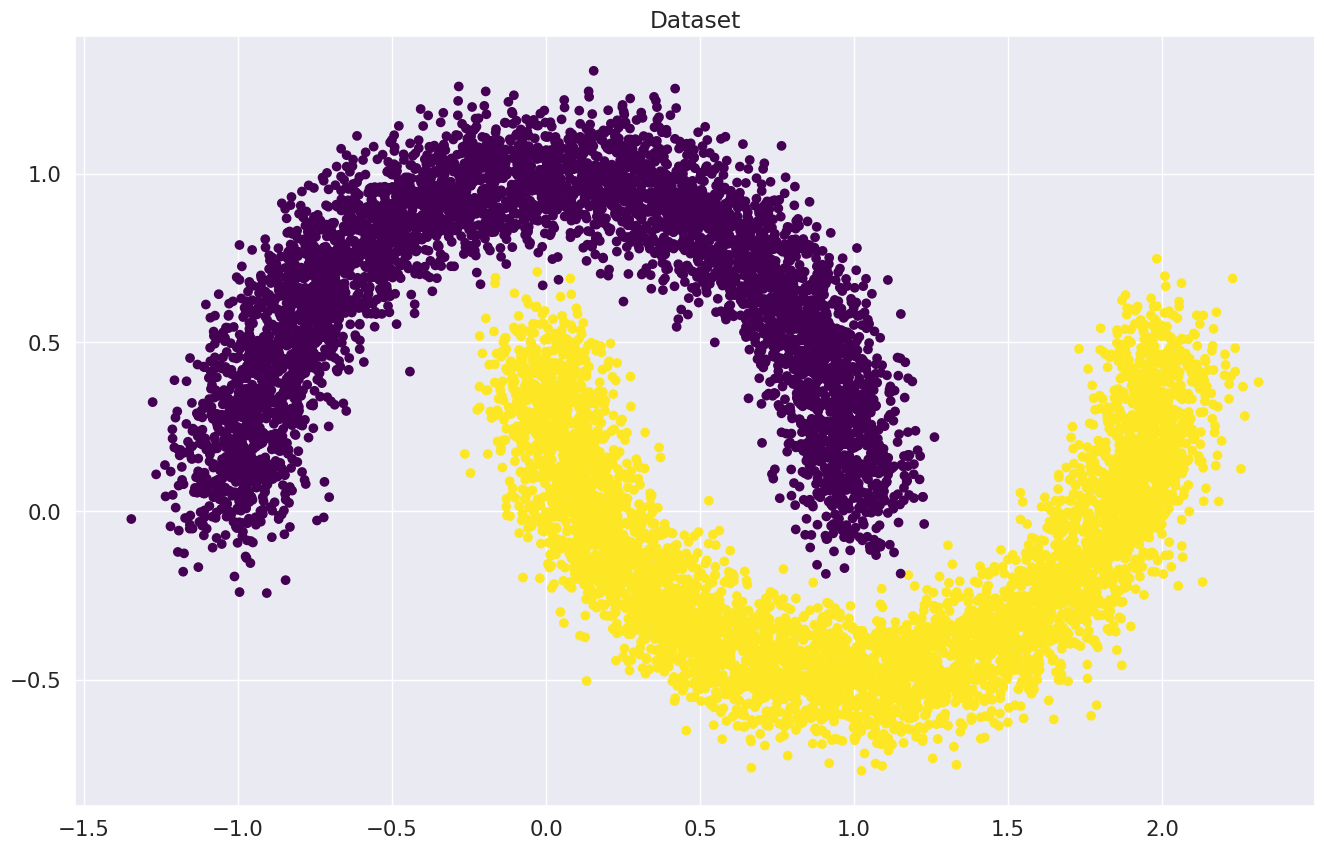

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.from_numpy(X_train).type_as(torch.FloatTensor())
y_train_t =  torch.from_numpy(y_train).type_as(torch.FloatTensor())
X_val_t =  torch.from_numpy(X_val).type_as(torch.FloatTensor())
y_val_t =  torch.from_numpy(y_val).type_as(torch.FloatTensor())

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
#Обучаются W и b, всего переменных:

#in_features * out_features + out_features

#2 * 1 + 1 = 3

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
sigmoid = nn.Sigmoid()
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch[:, None]) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.2890625
Iteration: 100
Batch accuracy: 0.546875
Iteration: 200
Batch accuracy: 0.8515625
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.90625
Iteration: 600
Batch accuracy: 0.8671875
Iteration: 700
Batch accuracy: 0.8359375

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

### Визуализируем результаты

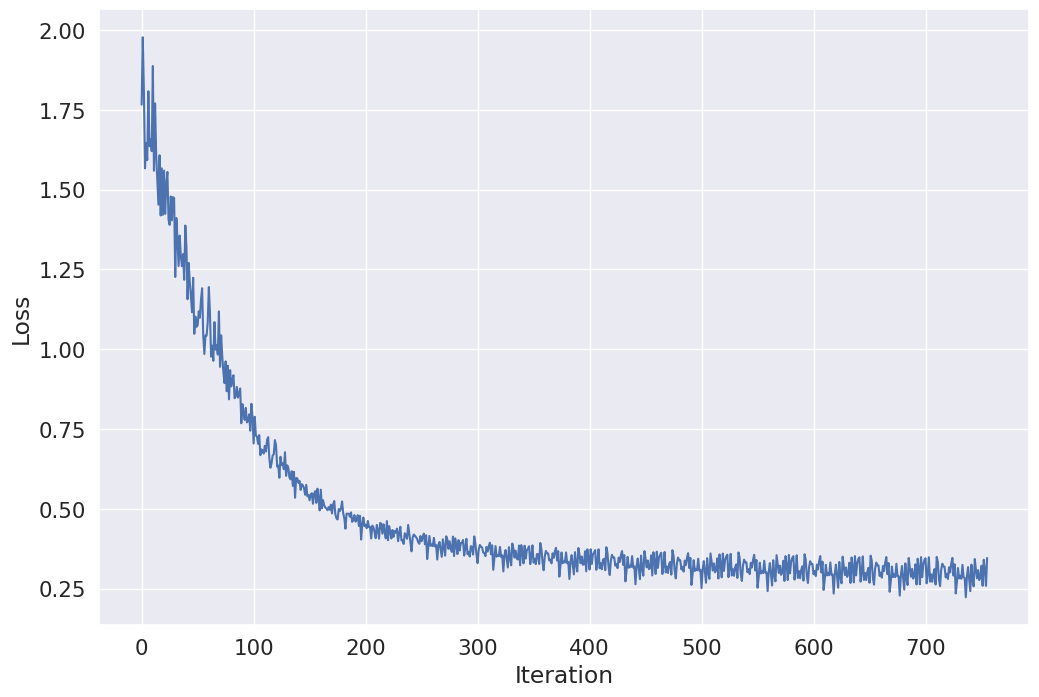

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

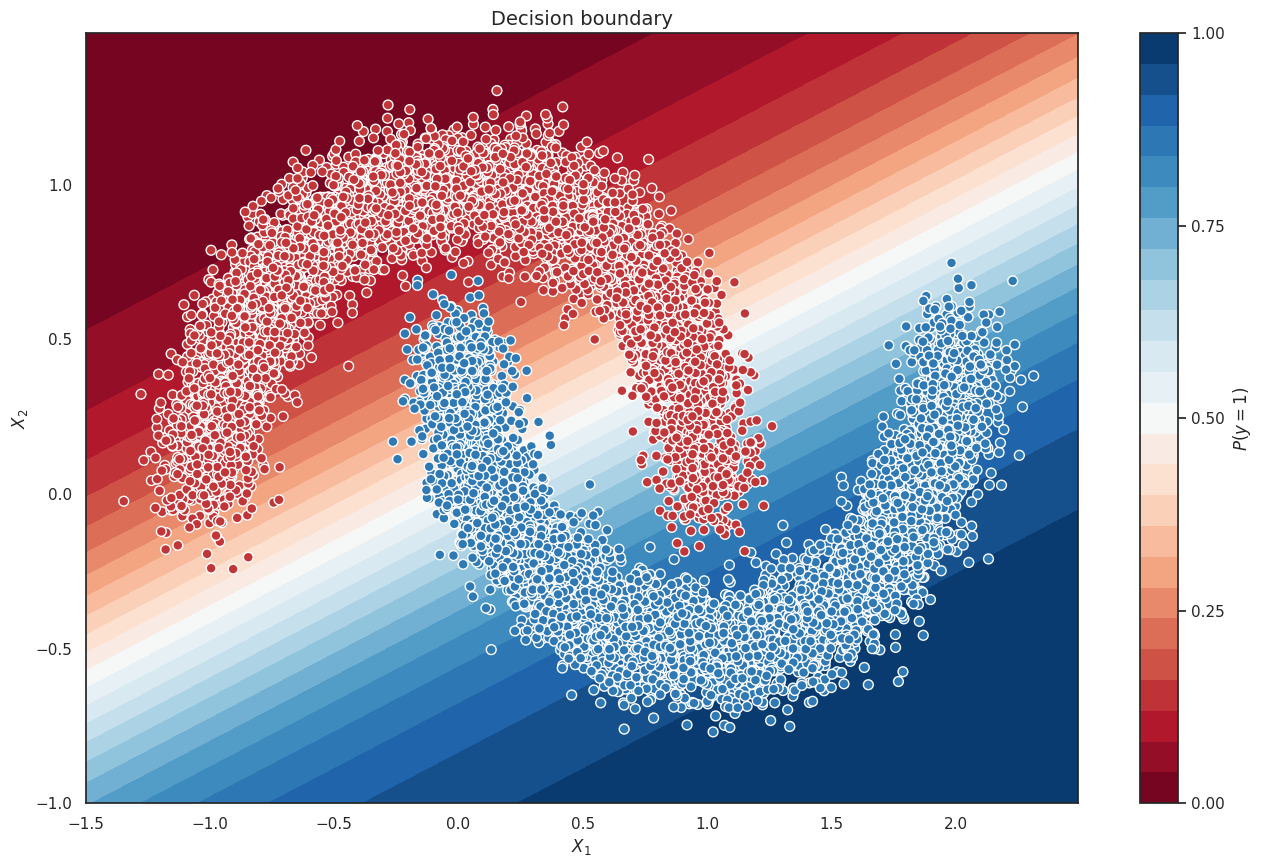

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model.forward(x_batch)
        probabil = sigmoid(outp)
        preds =  torch.IntTensor([1 if x >= 0.5 else 0 for x in probabil])
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)
accuracy_score(y_true=y_val_t, y_pred=predictions)
# YOUR CODE. Compute total accuracy

0.872

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.872.

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 63741107.82it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71635537.45it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38069685.77it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1312381.43it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
activation = nn.ELU
n_closed = 128
n_features = 28 * 28
n_exit = 10

model = nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(n_features, n_closed),
    activation(),
    torch.nn.Linear(n_closed, n_closed),
    activation(),
    torch.nn.Linear(n_closed, n_closed),
    activation(),
    torch.nn.Linear(n_closed, n_exit),
    #YOUR CODE. Add layers to your sequential class
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_loader, "valid": val_loader}

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Задание. Дополните цикл обучения.

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            if outp.shape[0] < 128:
                print(outp.shape)
                print(len(x_batch))
                print(len(y_batch))
                print(k)
            preds = outp.argmax(-1)
            correct =  sum([1 if preds[i] == y_batch[i] else 0 for i in range(len(preds))])
            
            all =  len(preds)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8792401175213675
Loader: valid. Accuracy: 0.9105568910256411
Epoch: 2
Loader: train. Accuracy: 0.9421407585470085
Loader: valid. Accuracy: 0.9495192307692307
Epoch: 3
Loader: train. Accuracy: 0.9575487446581197
Loader: valid. Accuracy: 0.9605368589743589
Epoch: 4
Loader: train. Accuracy: 0.9661291399572649
Loader: valid. Accuracy: 0.9674479166666666
Epoch: 5
Loader: train. Accuracy: 0.9721888354700855
Loader: valid. Accuracy: 0.9663461538461539
Epoch: 6
Loader: train. Accuracy: 0.9758613782051282
Loader: valid. Accuracy: 0.9664463141025641
Epoch: 7
Loader: train. Accuracy: 0.9791332799145299
Loader: valid. Accuracy: 0.9667467948717948
Epoch: 8
Loader: train. Accuracy: 0.9823717948717948
Loader: valid. Accuracy: 0.9685496794871795
Epoch: 9
Loader: train. Accuracy: 0.9839409722222222
Loader: valid. Accuracy: 0.9714543269230769
Epoch: 10
Loader: train. Accuracy: 0.9839242788461539
Loader: valid. Accuracy: 0.9708533653846154


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [29]:
elu_accuracy = accuracy["valid"]

In [23]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(n_features, n_closed),
      activation(),
      torch.nn.Linear(n_closed, n_closed),
      activation(),
      torch.nn.Linear(n_closed, n_closed),
      activation(),
      torch.nn.Linear(n_closed, n_exit),
  )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_loader, "valid": val_loader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                      outp = model(x_batch)
                if outp.shape[0] < 128:
                    print(outp.shape)
                    print(len(x_batch))
                    print(len(y_batch))
                    print(k)
                preds = outp.argmax(-1)
                correct =  sum([1 if preds[i] == y_batch[i] else 0 for i in range(len(preds))])
                
                all =  len(preds)
                epoch_correct += correct
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [24]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)


Epoch: 1
Loader: train. Accuracy: 0.8578225160256411
Loader: valid. Accuracy: 0.8744991987179487
Epoch: 2
Loader: train. Accuracy: 0.8898070245726496
Loader: valid. Accuracy: 0.8922275641025641
Epoch: 3
Loader: train. Accuracy: 0.8948818108974359
Loader: valid. Accuracy: 0.8930288461538461
Epoch: 4
Loader: train. Accuracy: 0.8984875801282052
Loader: valid. Accuracy: 0.8940304487179487
Epoch: 5
Loader: train. Accuracy: 0.9002737713675214
Loader: valid. Accuracy: 0.8944310897435898
Epoch: 6
Loader: train. Accuracy: 0.9024606036324786
Loader: valid. Accuracy: 0.8947315705128205
Epoch: 7
Loader: train. Accuracy: 0.9037960737179487
Loader: valid. Accuracy: 0.8964342948717948
Epoch: 8
Loader: train. Accuracy: 0.9051983173076923
Loader: valid. Accuracy: 0.897636217948718
Epoch: 9
Loader: train. Accuracy: 0.9066172542735043
Loader: valid. Accuracy: 0.8989383012820513
Epoch: 10
Loader: train. Accuracy: 0.9074853098290598
Loader: valid. Accuracy: 0.899238782051282
Epoch: 1
Loader: train. Accurac

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

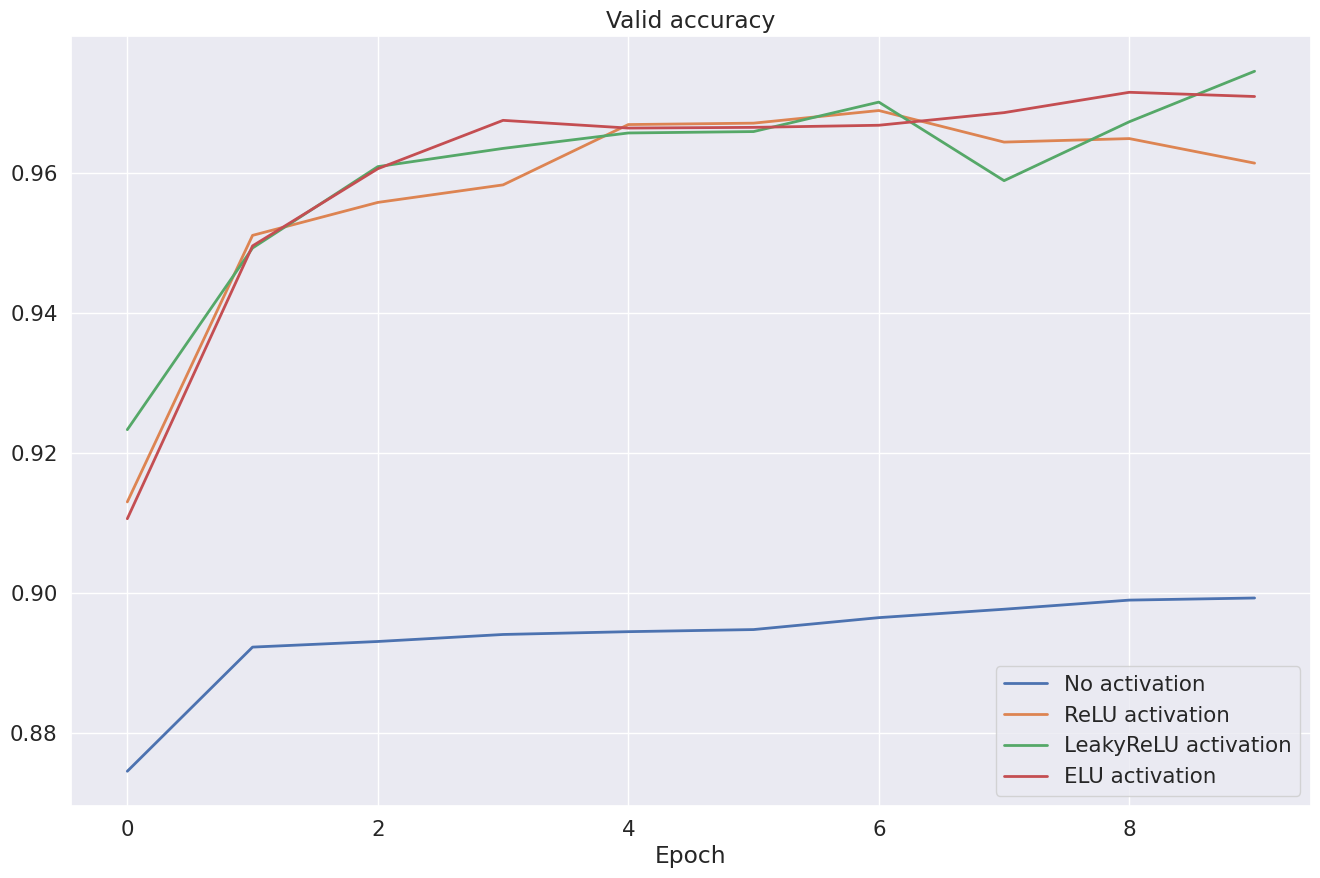

In [62]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

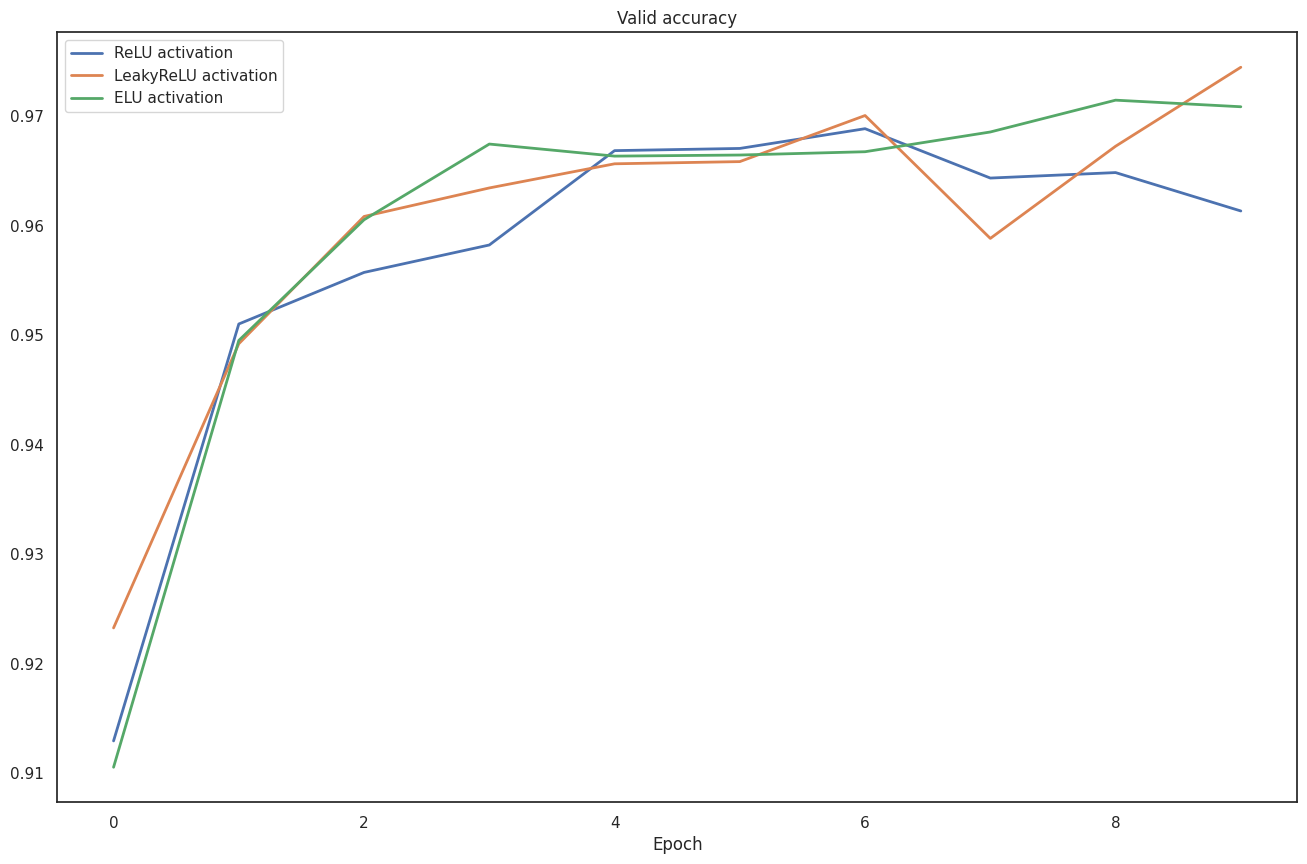

In [61]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [63]:
print(relu_accuracy['valid'][-1])
print(leaky_relu_accuracy['valid'][-1])
print(elu_accuracy[-1])

0.9613381410256411
0.9744591346153846
0.9708533653846154


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [36]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-07 18:01:17--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-07 18:01:18--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3036::ac43:80f6, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.008s  

2023-04-07 18:01:19 (5

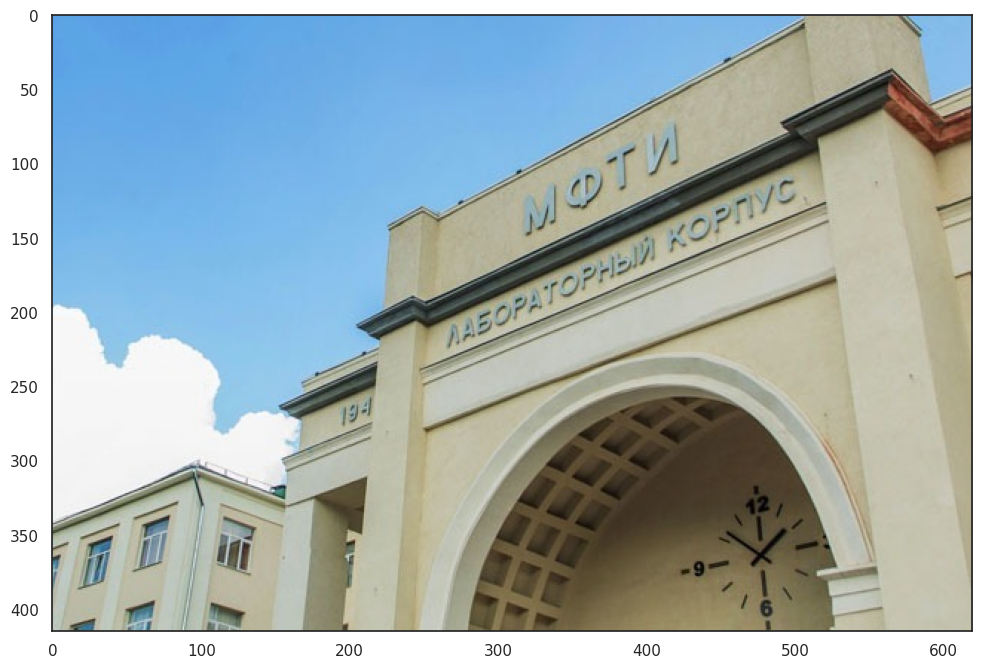

In [37]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [50]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

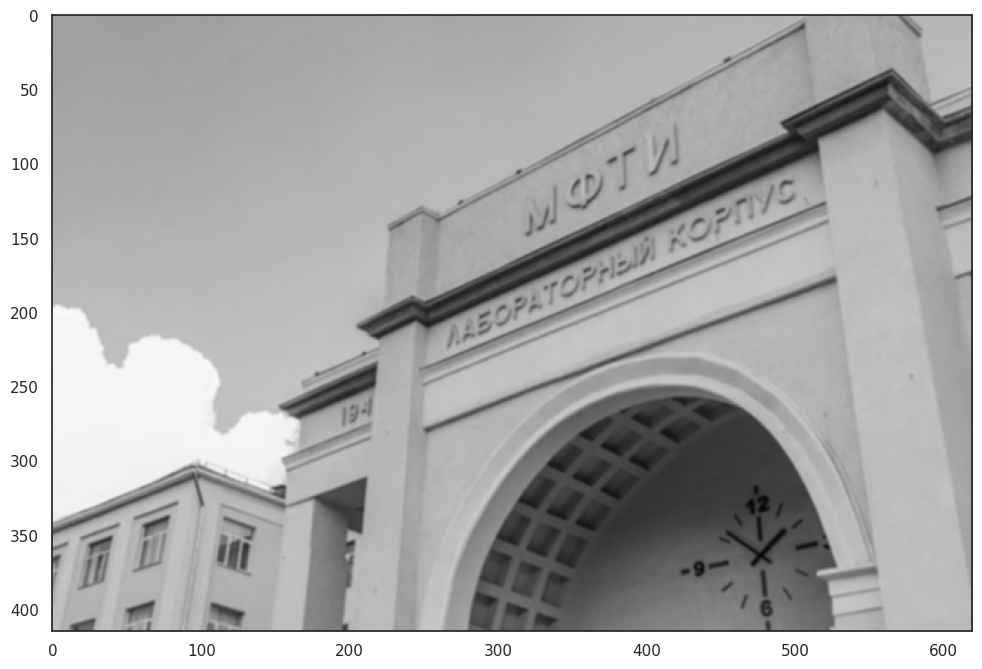

In [51]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А-3 , Б-5 , В-4 , Г-6 , Д-2 , Е-1. 

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [52]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [53]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_loader, "valid": val_loader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [54]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            if outp.shape[0] < 128:
                print(outp.shape)
                print(len(x_batch))
                print(len(y_batch))
                print(k)
            preds = outp.argmax(-1)
            correct =  sum([1 if preds[i] == y_batch[i] else 0 for i in range(len(preds))])
            
            all =  len(preds)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8605936164529915
Loader: valid. Accuracy: 0.9605368589743589
Epoch: 2
Loader: train. Accuracy: 0.9659788995726496
Loader: valid. Accuracy: 0.9717548076923077
Epoch: 3
Loader: train. Accuracy: 0.9756443643162394
Loader: valid. Accuracy: 0.9794671474358975
Epoch: 4
Loader: train. Accuracy: 0.9807692307692307
Loader: valid. Accuracy: 0.9829727564102564
Epoch: 5
Loader: train. Accuracy: 0.9847088675213675
Loader: valid. Accuracy: 0.9834735576923077
Epoch: 6
Loader: train. Accuracy: 0.9872295673076923
Loader: valid. Accuracy: 0.9840745192307693
Epoch: 7
Loader: train. Accuracy: 0.9893496260683761
Loader: valid. Accuracy: 0.9842748397435898
Epoch: 8
Loader: train. Accuracy: 0.9909855769230769
Loader: valid. Accuracy: 0.9838741987179487
Epoch: 9
Loader: train. Accuracy: 0.9922375801282052
Loader: valid. Accuracy: 0.9845753205128205
Epoch: 10
Loader: train. Accuracy: 0.9936732104700855
Loader: valid. Accuracy: 0.9847756410256411


In [55]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

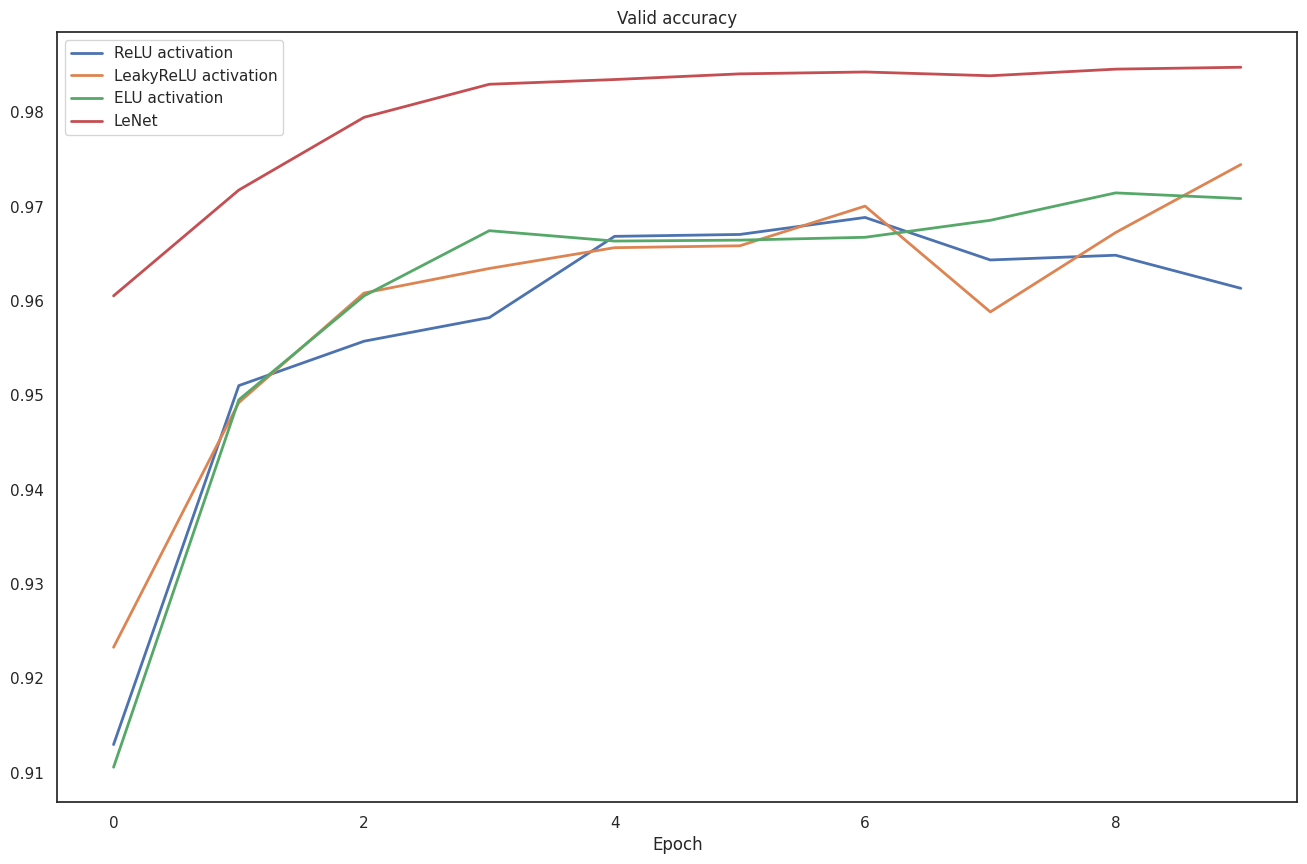

In [59]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [60]:
print(lenet_accuracy[-1])

0.9847756410256411


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98
